In [1]:
import torch
import torch.nn.functional as F

# Numerical aproximations

In [2]:
B = 5
C = 4
D = 6
h=0.001
A  = B * C + D
Adb = (B+h) * C + D
Adc = B * (C+h) + D
Add = B * C + (D+h)
da_db= (Adb-A)/h
da_dc= (Adc-A)/h
da_dd= (Add-A)/h

print(da_db, da_dc, da_dd)

4.000000000001336 5.000000000002558 1.0000000000012221


In [3]:
B = 5
D = 6

E=2
F=3
C = (E*F)


h=0.001
A  = B * C + D
Adb = (B+h) * C + D
Adc = B * (C+h) + D
Add = B * C + (D+h)
Ade = B * ((E+h)*F) + D
Adf = B * (E*(F+h)) + D
Cde = (E+h)*F
Cdf = E*(F+h)

da_db= (Adb-A)/h
Da_db= C
da_dc= (Adc-A)/h
Da_dc = B
da_dd= (Add-A)/h
Da_dd=1

da_de= (Ade-A)/h
da_df= (Adf-A)/h

dc_de= (Cde-C)/h
Dc_de=F
dc_df= (Cdf-C)/h
Dc_df=E


print(' da_db ',da_db,'\n da_dc', da_dc, '\n da_dd', da_dd,'\n dc_de', dc_de, '\n dc_df', dc_df, '\n da_de', da_de, '\n da_df', da_df)
print(f' da_df = da_dc x dc_df -> {da_df} = {da_dc} x {dc_df} \n da_de = da_dc x dc_de -> {da_de} = {da_dc} x {dc_de}')
print(f'COMPOSE FROM VARS\n da_df =  Da_dc x Dc_df -> {Da_dc*Dc_df} = {Da_dc} x {Dc_df} \n da_de = Da_dc x Dc_de -> {Da_dc*Dc_de} = {Da_dc} x {Dc_de}')

 da_db  6.000000000000227 
 da_dc 5.000000000002558 
 da_dd 0.9999999999976694 
 dc_de 3.0000000000001137 
 dc_df 1.9999999999997797 
 da_de 15.000000000000568 
 da_df 9.99999999999801
 da_df = da_dc x dc_df -> 9.99999999999801 = 5.000000000002558 x 1.9999999999997797 
 da_de = da_dc x dc_de -> 15.000000000000568 = 5.000000000002558 x 3.0000000000001137
COMPOSE FROM VARS
 da_df =  Da_dc x Dc_df -> 10 = 5 x 2 
 da_de = Da_dc x Dc_de -> 15 = 5 x 3


# Layers

In [4]:
class flatten:   
    def __call__(self, x):
        self.out = x.view(x.size(0), -1) #keep the batch dimension
        # self.out=torch.flatten(x)
        self.x=x
        return self.out
    def parameters(self):
        return []
    def back(self):
        with torch.no_grad():
            self.grad= torch.ones_like(self.x)
        return self.grad
    
class simple_sum:
    def __init__(self, dim=0, keepdims=True):
        self.dim=dim
        self.keepdims=keepdims
    def __call__(self, x):
        self.out = x.sum(dim=self.dim, keepdims=self.keepdims)
        self.x=x
        return self.out
    def back(self):
        with torch.no_grad():
            self.grad= torch.ones_like(self.x)
        return self.grad
    def parameters(self):
        return []

class simple_mul:
    def __init__(self):
        self.scalar=torch.rand(1, requires_grad=True)
    def __call__(self, x):
        self.x=x
        self.out = x*self.scalar
        return self.out 
    def back(self):
        with torch.no_grad():
            self.scalar_grad= self.x #even though scalar is a single element the dimensions should be the broadcasted element trhough the whole input, ergo must match x and only when updating the parameter should be summed to a sinlge scalar value
            self.grad=torch.ones_like(self.x)*self.scalar
        return self.grad   
    def parameters(self):
        return []

class simple_relu:
    def __call__(self, x):
        self.x=x
        self.out= torch.maximum(x, torch.zeros_like(x))
        return self.out
    def back(self):
        with torch.no_grad():
            mask=self.x > 0 #alternative mask -> self.out > 0 but in any case if self.x > 0 then self.out > 0 and self.out <= 0 otherwise so both options should lead to the same mask
            self.grad=mask*1.0
        return self.grad
    def parameters(self):
        return []

class simple_linear:
    def __init__(self, fan_in, fan_out, generator):
        self.w = torch.randn(fan_in, fan_out, generator=generator, requires_grad=True)
    
    def __call__(self, x):
        self.x=x
        self.out= x @ self.w
        return self.out
    
    def back(self):
        with torch.no_grad():
            self.w_grad=self.x.T
            self.grad=self.w.T
        return self.grad
    
    def parameters(self):
        return [self.w] 


In [5]:
simp=simple_sum()
x=torch.randn(2)
x.requires_grad=True
print(x)
out=simp(x)
print('out',out)
print('x.grad',x.grad)
out.backward()

print('out.grad',out.grad)
print('x.grad',x.grad)

simp.back(),simp.x.grad

tensor([ 1.6351, -0.9510], requires_grad=True)
out tensor([0.6841], grad_fn=<SumBackward1>)
x.grad None
out.grad None
x.grad tensor([1., 1.])


/tmp/ipykernel_947/2354017059.py:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print('out.grad',out.grad)


(tensor([1., 1.]), tensor([1., 1.]))

In [6]:
simpm=simple_mul()
y=torch.randn(2)
y.requires_grad=True
print(y)
outm=simpm(y)
print('outm',outm)
print('y.grad',y.grad)
outm_sum=outm.sum(0)
outm_sum.backward()
# print('outm.grad',outm.grad)
print('y.grad',y.grad)

tensor([-1.4480, -0.4927], requires_grad=True)
outm tensor([-0.6953, -0.2366], grad_fn=<MulBackward0>)
y.grad None
y.grad tensor([0.4802, 0.4802])


In [7]:
simpm.scalar, simpm.back(),simpm.x.grad, simpm.scalar.grad, simpm.scalar_grad,

(tensor([0.4802], requires_grad=True),
 tensor([0.4802, 0.4802]),
 tensor([0.4802, 0.4802]),
 tensor([-1.9407]),
 tensor([-1.4480, -0.4927], requires_grad=True))

In [8]:
sum1=simple_sum(0)
mul1=simple_mul()
sum2=simple_sum(1, keepdims=False)
j=torch.randn(2,2, requires_grad=True)
j.retain_grad()
k=sum1(j)
k.retain_grad()
l=mul1(k)
l.retain_grad()
# m=torch.sum(l)
m=sum2(l)
m.retain_grad()
m.backward()
print('j:',j, '\nk:', k , '\nl:',l,'\nm:', m,'\nmul1.scalar:', mul1.scalar)


j: tensor([[ 0.2523,  0.9799],
        [ 1.9049, -0.4440]], requires_grad=True) 
k: tensor([[2.1571, 0.5359]], grad_fn=<SumBackward1>) 
l: tensor([[1.4459, 0.3592]], grad_fn=<MulBackward0>) 
m: tensor([1.8051], grad_fn=<SumBackward1>) 
mul1.scalar: tensor([0.6703], requires_grad=True)


In [9]:
# dm_dj = dm_dl*dl_dk*dk_dj
#dm_dl -> sum2 ->  [1, 1] -> dimensions = l.dimensions
#dl_dk -> mul1 -> [mul1.scalar, mul1.scalar] -> dimensions = k.dimensions
#dk_dj -> sum1 -> [[1., 1.],
#                  [1., 1.]] -> dimensions = j.dimensions
#dm_dj = [[mul1.scalar, mul1.scalar],
#         [mul1.scalar, mul1.scalar]] -> dimensions = j.dimensions

print('mul1.back()',mul1.back(), '\nmul1.scalar_grad', mul1.scalar_grad, '\nmul1.scalar.grad', mul1.scalar.grad)
print('sum1.back()',sum1.back())
print('j.grad', j.grad, j.shape, '\nk.grad',k.grad,k.shape,'\nl.grad',l.grad,l.shape,'\nm.grad',m.grad, m.shape)
print('mul1.scalar.grad',mul1.scalar.grad)
print('*************** calculated with .back() in each layer********************')

mul1_back=mul1.back() #dl_dk
sum1_back=sum1.back() #dk_dj
sum2_back=sum2.back() #dm_dl

print('dm_dl -> l grad ',sum2_back )
print('dm_dk = dm_dl*dl_dk = sum2.back() * mul1.back() ')
back = sum2.back() * mul1_back 
print('k grad -> md_dk',back, 'back.shape',back.shape)
back = back *sum1_back
print('dm_dj = dm_dl*dl_dk*dk_dj = sum2.back() * sum1.back() * mul1.back()')
print('dm_dj = dm_dk*dk_dj = sum2.back() * sum1.back() * mul1.back()')
print('j grad -> dm_dj',back, 'back.shape',back.shape)


mul1.back() tensor([[0.6703, 0.6703]]) 
mul1.scalar_grad tensor([[2.1571, 0.5359]], grad_fn=<SumBackward1>) 
mul1.scalar.grad tensor([2.6930])
sum1.back() tensor([[1., 1.],
        [1., 1.]])
j.grad tensor([[0.6703, 0.6703],
        [0.6703, 0.6703]]) torch.Size([2, 2]) 
k.grad tensor([[0.6703, 0.6703]]) torch.Size([1, 2]) 
l.grad tensor([[1., 1.]]) torch.Size([1, 2]) 
m.grad tensor([1.]) torch.Size([1])
mul1.scalar.grad tensor([2.6930])
*************** calculated with .back() in each layer********************
dm_dl -> l grad  tensor([[1., 1.]])
dm_dk = dm_dl*dl_dk = sum2.back() * mul1.back() 
k grad -> md_dk tensor([[0.6703, 0.6703]]) back.shape torch.Size([1, 2])
dm_dj = dm_dl*dl_dk*dk_dj = sum2.back() * sum1.back() * mul1.back()
dm_dj = dm_dk*dk_dj = sum2.back() * sum1.back() * mul1.back()
j grad -> dm_dj tensor([[0.6703, 0.6703],
        [0.6703, 0.6703]]) back.shape torch.Size([2, 2])


## adding  relu

In [10]:
rsum1=simple_sum(0)
rmul1=simple_mul()
relu1=simple_relu()
rsum2=simple_sum(1, keepdims=False)

j=torch.randn(2,2, requires_grad=True)
j.retain_grad()
k=rsum1(j)
k.retain_grad()
l=rmul1(k)
l.retain_grad()
r=relu1(l)
r.retain_grad()
m=rsum2(r)
m.retain_grad()
m.backward()
print('j:',j, '\nk:', k , '\nl:',l, '\nr:',r,'\nm:', m,'\nmul1.scalar:', rmul1.scalar)

j: tensor([[ 0.4599, -0.3250],
        [-0.4460,  0.8312]], requires_grad=True) 
k: tensor([[0.0139, 0.5061]], grad_fn=<SumBackward1>) 
l: tensor([[0.0120, 0.4363]], grad_fn=<MulBackward0>) 
r: tensor([[0.0120, 0.4363]], grad_fn=<MaximumBackward0>) 
m: tensor([0.4483], grad_fn=<SumBackward1>) 
mul1.scalar: tensor([0.8621], requires_grad=True)


In [11]:
# dm_dj = dm_dr*dr_dl*dl_dk*dk_dj
#dm_dr -> sum2 ->  [1, 1] -> dimensions = l.dimensions
#dr_dl -> relu1 -> [max(0,l1)>0,max(0,l2)>0] -> dimensions = l.dimensions -> max(0,l2)>0 gives 1 if >0 and 0 if = 0
#dl_dk -> mul1 -> [mul1.scalar, mul1.scalar] -> dimensions = k.dimensions
#dk_dj -> sum1 -> [[1., 1.],
#                  [1., 1.]] -> dimensions = j.dimensions
#dm_dj = [[mul1.scalar, mul1.scalar],
#         [mul1.scalar, mul1.scalar]] -> dimensions = j.dimensions
print('***local derivatives***')
print('rsum2.back()',rsum2.back())
print('relu1.back()',relu1.back())
print('mul1.back()',rmul1.back())
print('mul1.scalar',rmul1.scalar_grad)
print('sum1.back()',rsum1.back())
print('***global derivatives from autograd***')
print('j.grad', j.grad, j.shape, '\nk.grad',k.grad,k.shape,'\nl.grad',l.grad,l.shape,'\nr.grad',r.grad,r.shape,'\nm.grad',m.grad, m.shape)
print('mul1 scalar grad = ', rmul1.scalar.grad)
print('***global derivatives applying chain rule in each layer .back() method***')

sum1_back=rsum1.back() #dk_dj
mul1_back=rmul1.back() #dl_dk
relu1_back=relu1.back() #dk_dj
sum2_back=rsum2.back() #dm_dl
mul1_sback = rmul1.scalar_grad

print('r grad -> dm_dr  ',sum2_back )
# print('l grad -> dr_dl   ',relu1_back )
print('*')
print('dm_dl = dm_dr*dr_dl = sum2.back() * relu1.back() ')
back1 = sum2_back * relu1_back
print('l grad -> dm_dl',back1, 'back.shape',back1.shape)
print('*')
print('dm_dk = dm_dr*dr_dl*dl_dk = dm_dl*dl_dk = l grad *mul1.back() ')
back2 = back1 * mul1_back
print('k grad -> dm_dk',back2, 'back.shape',back2.shape)
print('*')
print('dm_dj = dm_dr*dr_dl*dl_dk*dk_dj = dm_dk*dk_dj = k grad * sum1_back ')
back3 = back2 *sum1_back
print('j grad -> dm_dj',back3, 'back.shape',back3.shape)

print('mul1.scalar_grad = dm_dr*dr_dl*dl_dscalar = dm_dl*dl_dscalar = l grad* mul1_sback')
sback = back1 * mul1_sback
with torch.no_grad():
    sback=sback.sum() #add scalar derivative in each element
print('mul1 scalar grad =', sback)






***local derivatives***
rsum2.back() tensor([[1., 1.]])
relu1.back() tensor([[1., 1.]])
mul1.back() tensor([[0.8621, 0.8621]])
mul1.scalar tensor([[0.0139, 0.5061]], grad_fn=<SumBackward1>)
sum1.back() tensor([[1., 1.],
        [1., 1.]])
***global derivatives from autograd***
j.grad tensor([[0.8621, 0.8621],
        [0.8621, 0.8621]]) torch.Size([2, 2]) 
k.grad tensor([[0.8621, 0.8621]]) torch.Size([1, 2]) 
l.grad tensor([[1., 1.]]) torch.Size([1, 2]) 
r.grad tensor([[1., 1.]]) torch.Size([1, 2]) 
m.grad tensor([1.]) torch.Size([1])
mul1 scalar grad =  tensor([0.5200])
***global derivatives applying chain rule in each layer .back() method***
r grad -> dm_dr   tensor([[1., 1.]])
*
dm_dl = dm_dr*dr_dl = sum2.back() * relu1.back() 
l grad -> dm_dl tensor([[1., 1.]]) back.shape torch.Size([1, 2])
*
dm_dk = dm_dr*dr_dl*dl_dk = dm_dl*dl_dk = l grad *mul1.back() 
k grad -> dm_dk tensor([[0.8621, 0.8621]]) back.shape torch.Size([1, 2])
*
dm_dj = dm_dr*dr_dl*dl_dk*dk_dj = dm_dk*dk_dj = k grad 

## adding linear

In [12]:
generator=torch.Generator().manual_seed(23)
lin=simple_linear(2,2, generator=generator)
relu=simple_relu()
sum1=simple_sum(1, keepdims=False)
sum2=simple_sum(0, keepdims=False)

j=torch.randn(2,2, requires_grad=True)
j.retain_grad()
k=lin(j)
k.retain_grad()
l=relu(k)
l.retain_grad()
m=sum1(l)
m.retain_grad()
n=sum2(m)
n.retain_grad()
n.backward()
print('j:',j, '\nk:', k , '\n linear w:',lin.w, '\nl:',l, '\nm:', m, '\nn:', n)


j: tensor([[ 1.0550, -0.2669],
        [-0.5707, -0.0666]], requires_grad=True) 
k: tensor([[-0.7915,  0.6709],
        [ 0.5308, -0.1976]], grad_fn=<MmBackward0>) 
 linear w: tensor([[-0.8733,  0.4376],
        [-0.4866, -0.7840]], requires_grad=True) 
l: tensor([[0.0000, 0.6709],
        [0.5308, 0.0000]], grad_fn=<MaximumBackward0>) 
m: tensor([0.6709, 0.5308], grad_fn=<SumBackward1>) 
n: tensor(1.2017, grad_fn=<SumBackward1>)


In [13]:
# dn_dj = dn_dm*dm_dl*dl_dk*dk_dj
#dk_dj -> rlin -> (2,2)  -> dimensions = k.dimensions
#dl_dk -> relu -> (2,2) -> dimensions = l.dimensions 
#dm_dl -> sum1 -> ()-> dimensions = k.dimensions
#dn_dm -> sum2 -> ()-> dimensions = j.dimensions
#dn_dj =  -> dimensions = j.dimensions
print('***local derivatives***')
print('sum2.back()',sum2.back())
print('sum1.back()',sum1.back())
print('relu.back()',relu.back())
print('lin.back()',lin.back())
print('lin.w',lin.w)
print('***global derivatives from autograd***')
print('j.grad', j.grad, j.shape, '\nk.grad',k.grad,k.shape,'\nl.grad',l.grad,l.shape,'\nm.grad',m.grad,m.shape,'\nn.grad',n.grad, n.shape)

print('lin.w.grad', lin.w.grad)


print('***global derivatives applying chain rule in each layer .back() method***')

sum2_back=sum2.back() #dn_dm
sum1_back=sum1.back() #dm_dl
relu_back=relu.back() #dl_dk
lin_back=lin.back()  #dk_dj
lin_w_back=lin.w_grad #dk_dw

print('m grad -> dn_dm  ',sum2_back )
print('*')
print('dn_dl = dn_dm*dm_dl = sum2.back() * sum1_back ')
back1 = sum2_back * sum1_back
print('l grad -> dn_dl',back1, 'back.shape',back1.shape)
print('*')
print('dn_dk = dn_dm*dm_dl*dl_dk = dn_dl*dl_dk = l grad *relu_back ')
back2 = back1 * relu_back
print('k grad -> dn_dk',back2, 'back.shape',back2.shape)
print('*')
print('dn_dj = dn_dm*dm_dl*dl_dk*dk_dj = dn_dk*dk_dj = k grad * lin_back ')
back3 = back2 @lin_back
print('j grad -> dn_dj',back3, 'back.shape',back3.shape)
print('w.grad -> dn_dw', lin_w_back@ back2)
# print('mul1.scalar_grad = dm_dr*dr_dl*dl_dscalar = dm_dl*dl_dscalar = l grad* lin_back')
# sback = back1 * mul1_sback
# with torch.no_grad():
#     sback=sback.sum() #add scalar derivative in each element
# print('mul1 scalar grad =', sback)

***local derivatives***
sum2.back() tensor([1., 1.])
sum1.back() tensor([[1., 1.],
        [1., 1.]])
relu.back() tensor([[0., 1.],
        [1., 0.]])
lin.back() tensor([[-0.8733, -0.4866],
        [ 0.4376, -0.7840]], requires_grad=True)
lin.w tensor([[-0.8733,  0.4376],
        [-0.4866, -0.7840]], requires_grad=True)
***global derivatives from autograd***
j.grad tensor([[ 0.4376, -0.7840],
        [-0.8733, -0.4866]]) torch.Size([2, 2]) 
k.grad tensor([[0., 1.],
        [1., 0.]]) torch.Size([2, 2]) 
l.grad tensor([[1., 1.],
        [1., 1.]]) torch.Size([2, 2]) 
m.grad tensor([1., 1.]) torch.Size([2]) 
n.grad tensor(1.) torch.Size([])
lin.w.grad tensor([[-0.5707,  1.0550],
        [-0.0666, -0.2669]])
***global derivatives applying chain rule in each layer .back() method***
m grad -> dn_dm   tensor([1., 1.])
*
dn_dl = dn_dm*dm_dl = sum2.back() * sum1_back 
l grad -> dn_dl tensor([[1., 1.],
        [1., 1.]]) back.shape torch.Size([2, 2])
*
dn_dk = dn_dm*dm_dl*dl_dk = dn_dl*dl_dk = 

# tests

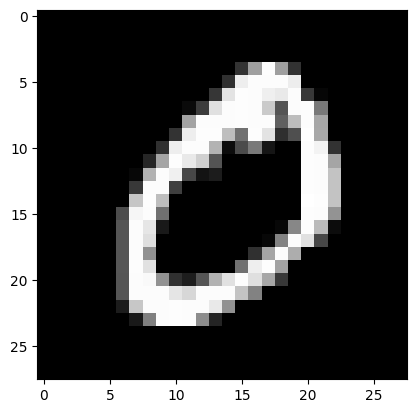

In [ ]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
import torch.nn.functional as F

root = './MNIST/'
dataset = torchvision.datasets.MNIST(root = root, train = True, transform = transforms.ToTensor())
x= dataset.__getitem__(1)
plt.imshow(x[0].squeeze(), cmap='gray');

In [15]:
train_size=0.9*len(dataset)
val_size=0.1*len(dataset)
train_dataset, val_dataset = random_split(dataset, [int(train_size),int(val_size) ])

## Back REF


In [16]:
input_size=784
inner_size=128
output_size=64
cat_size=10
generator=torch.Generator().manual_seed(23)
layers = [
    flatten(),
    simple_linear(input_size,inner_size, generator=generator),
    simple_relu(),
    simple_linear(inner_size, cat_size,generator=generator)
]
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

In [17]:
def forward(layers, x): 
    # print(x.shape)
    for layer in layers:
        x=layer(x)
    return x

In [18]:
lr = 0.01
iteration = 0
steps=40000
batch_size = 10
epochs=3

loss_steps=1000

steps_data = 500

# batching
subset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

i=0
for epoch in range(epochs):
    for batch_x, batch_y in subset_loader:


        len_dataset=len(train_dataset)
        index = torch.randint(low=1, high=len_dataset, size=(), generator=generator)

        row=train_dataset.__getitem__(index)

        out=forward(layers,batch_x.squeeze())
        
        # out1 = layers[0](batch_x.squeeze())
        # out2 = layers[1](out1)
        # out3 = layers[2](out2)
        # out = layers[3](out3)



        # loss = F.cross_entropy(out.squeeze(),torch.tensor(row[1]))
        loss = F.cross_entropy(out.squeeze(),batch_y)
        
        for layer in layers:
            if not isinstance(layer, flatten):
                layer.out.retain_grad() 
                
        for p in parameters:
            p.grad = None
        loss.backward()

        # print( out1.grad)    
        # print(out2.grad.shape, out2.grad)    
        # print(out3.grad.shape, out3.grad)    
        # print(out.grad.shape, out.grad)    
        
        
        #update parameters
        for p in parameters:
            p.data += -lr*p.grad
        
        if i % loss_steps == 0:
            with torch.no_grad():
                losses=torch.zeros(loss_steps)
                for j in range(loss_steps):
                    index2 = torch.randint(low=1, high=len_dataset, size=())
                    row_loss=train_dataset.__getitem__(index2)
                    out_loss = out=forward(layers,row_loss[0])
                    losses[j] = F.cross_entropy(out_loss.squeeze(),torch.tensor(row_loss[1]))
                print(f'step = {i}, loss = {losses.mean()}')
        i+=1
    #     break
    # break


step = 0, loss = 90.87871551513672
step = 1000, loss = 4.206167697906494
step = 2000, loss = 3.218306064605713
step = 3000, loss = 3.0621256828308105
step = 4000, loss = 2.883694648742676
step = 5000, loss = 1.7917462587356567
step = 6000, loss = 1.8851057291030884
step = 7000, loss = 1.4923591613769531
step = 8000, loss = 1.9077317714691162
step = 9000, loss = 1.2714887857437134
step = 10000, loss = 1.1899243593215942
step = 11000, loss = 1.0131828784942627
step = 12000, loss = 0.9760293960571289
step = 13000, loss = 0.6465086936950684
step = 14000, loss = 0.9031386971473694
step = 15000, loss = 0.7745187878608704
step = 16000, loss = 0.7963555455207825


## Back manual

In [19]:
input_size=784
inner_size=128
output_size=64
cat_size=10
generator=torch.Generator().manual_seed(23)
layers = [
    flatten(),
    simple_linear(input_size,inner_size, generator=generator),
    simple_relu(),
    simple_linear(inner_size, cat_size,generator=generator)
]
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:    
    p.requires_grad=True

In [20]:
def backward(layers, loss, lr, out_grad):
    
    with torch.no_grad():
        layer_back=out_grad
        for layer in reversed(layers):
               
            if (isinstance(layer, simple_linear) and (layer_back.dim() > 0)):
                        
                linear_back=layer.back() 
                w_grad=layer.w_grad@layer_back #weights gradients
                
                # print(layer_back.shape, layer_back)
                layer_back @=linear_back
                # print(layer_back.shape, layer_back)
                
                
                #Update weights
                layer.w.data +=-lr*w_grad
                continue
            if isinstance(layer, flatten):
                layer_back =layer_back.view(layer.back().shape)    
                continue
            
            layer_back=layer.back()*layer_back
            

In [21]:
lr = 0.01
iteration = 0
steps=40000
batch_size = 10
epochs=3

loss_steps=1000

steps_data = 500

# batching
subset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

i=0
for epoch in range(epochs):
    for batch_x, batch_y in subset_loader:

        len_dataset=len(train_dataset)
        index = torch.randint(low=1, high=len_dataset, size=(), generator=generator)

        row=train_dataset.__getitem__(index)
        
        out=forward(layers,batch_x.squeeze())
        
        loss = F.cross_entropy(out.squeeze(),batch_y)
        
        for layer in layers:
            if not isinstance(layer, flatten):
                layer.out.retain_grad() 
        
        loss.backward() # only used to compute the loss function gradient and for comparison purposes

        backward(layers, loss, lr, out.grad.detach()) #TODO ot.grad.detach() -> replace for actual calculation for DLoss/Dout
        
        if i % loss_steps == 0:
            with torch.no_grad():
                losses=torch.zeros(loss_steps)
                for j in range(loss_steps):
                    index2 = torch.randint(low=1, high=len_dataset, size=())
                    row_loss=train_dataset.__getitem__(index2)
                    out_loss = out=forward(layers,row_loss[0])
                    losses[j] = F.cross_entropy(out_loss.squeeze(),torch.tensor(row_loss[1]))
                print(f'step = {i}, loss = {losses.mean()}')
        i+=1
    #     break
    # break
        
    

            

step = 0, loss = 88.32403564453125
step = 1000, loss = 4.905978202819824
step = 2000, loss = 3.855635166168213
step = 3000, loss = 2.7997183799743652
step = 4000, loss = 2.5361340045928955
step = 5000, loss = 1.8017687797546387
step = 6000, loss = 1.4710537195205688
step = 7000, loss = 1.3238192796707153
step = 8000, loss = 1.3564379215240479
step = 9000, loss = 1.382887363433838
step = 10000, loss = 1.340439796447754
step = 11000, loss = 1.3557485342025757
step = 12000, loss = 0.9448175430297852
step = 13000, loss = 0.6130043268203735
step = 14000, loss = 0.8625460267066956
step = 15000, loss = 0.7904998660087585
step = 16000, loss = 0.6841990947723389


# Predictions

tensor([[-27.2183, -49.0154,  41.6950,  44.3113, -26.0812,   1.2192, -63.0770,
         -23.3116,  36.7450,  13.7780]])
<class 'torch.Tensor'>
3


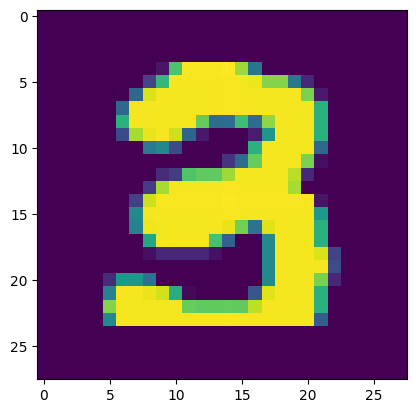

In [27]:
x= val_dataset.__getitem__(189)
with torch.no_grad():
    output =forward(layers,x[0])
    print(output)
    print(type(output))
    print(torch.argmax(F.softmax(output,1)).item())
plt.imshow(x[0].squeeze());